### Importación de librerías

In [8]:
import pandas as pd
import numpy as np
import os
from dateutil import parser
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
import gc
import seaborn as sns
from tqdm import tqdm

### Lectura del archivo excel con la información de los clientes

In [2]:
df_tabla_final = pd.read_excel("archivos_entrada_script/tabla_final.xlsx", sheet_name="Hoja2")
df_tabla_final["CODIGOCLIE"] = df_tabla_final["CODIGOCLIE"].astype("string")
df_tabla_final = df_tabla_final.iloc[:,2:6]
df_tabla_final

,Nombre,CIIU,CODIGOCLIE,Mult. de potencias
0,LA INDUSTRIA HARINERA S.A,C1061.11,1401867926.0,1100.0
1,CONFITECA,C1073.21,1490000744.0,1100.0
2,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,1490000688.0,1100.0
3,"AC BEBIDAS, S. DE R.L. DE C.V.",C1104.01,1490001175.0,400.0
4,S.J. JERSEY ECUATORIANO C.A.,C1311.02,1490000515.0,800.0
...,...,...,...,...
209,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,1410020880.0,1140.0
210,ECUATORIANA DE ARTEFACTOS S.A. ECASA,C2750.01,1490000693.0,1.0
211,INTEXDECOR S.A.,G4641.11,1490001644.0,1000.0
212,INTELA INDUSTRIA TEXTIL LATINOAMERICANA CIA. L...,C1312.01,1410062892.0,1100.0


In [3]:
clientes_unicos = df_tabla_final["CODIGOCLIE"].unique()
print(clientes_unicos)

<StringArray>
['1401867926.0', '1490000744.0', '1490000688.0', '1490001175.0',
 '1490000515.0', '1401337167.0', '1490002225.0', '1401582655.0',
 '1490001247.0', '1401282968.0',
 ...
 '1401229975.0', '1401954998.0', '1490000719.0', '1401940609.0',
 '1410026628.0', '1410020880.0', '1490000693.0', '1490001644.0',
 '1410062892.0', '1490002155.0']
Length: 214, dtype: string


In [4]:
def intentar_abrir_archivo_datos(path_archivo):

    df_archivo_telem_tab = pd.DataFrame([1,2,3,4], columns=["Prueba"])
    df_archivo_telem_pc = pd.DataFrame([1,2,3,4], columns=["Prueba"])
    df_archivo_telem_c = pd.DataFrame([1,2,3,4], columns=["Prueba"])

    # Intentar leer el archivo con separador 'tab'
    try:
        #print("Leyendo con tab")
        df_archivo_telem_tab = pd.read_csv(path_archivo,
                                            sep="\t",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            ) 
    except:
        pass

    # Intentar leer el archivo con separador 'punto y coma'
    try:
        #print("Leyendo con ;")
        df_archivo_telem_pc = pd.read_csv(path_archivo,
                                            sep=";",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            #encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            )

    except:
        pass

    # Intentar leer el archivo con separador 'coma'
    try:
        #print("Leyendo con ,")
        df_archivo_telem_c = pd.read_csv(path_archivo,
                                            sep=",",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            #encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            )

    except:
        pass



    if len(df_archivo_telem_tab.columns) > 1:
        df_archivo_telem = df_archivo_telem_tab.copy()
    elif len(df_archivo_telem_pc.columns) > 1:
        df_archivo_telem = df_archivo_telem_pc.copy()
    else:
        df_archivo_telem = df_archivo_telem_c.copy()

    return df_archivo_telem

### 1. Unificación de los datos por año para cada cliente

#### 1.1 Primer grupo de clientes entregados

Estos clientes están clasificados por CUEN, y el formato de sus archivos varían, el procedimiento a seguir será:
1. Iterar sobre cada código de cliente
2. Buscar sus archivos de datos mensuales
3. Unificar todos en un solo archivo
4. El identificador a usar es el código de cliente

In [33]:
columnas_extraer = ["Fecha","Origen","Demanda activa DEL","Demanda reactiva DEL"]

mediciones_por_mes = os.scandir("mediciones_originales/mediciones_por_mes")
clientes_unicos = set()

for medicion in mediciones_por_mes:
    cliente = medicion.name.split('-')[1]
    clientes_unicos.add(cliente)

print(len(clientes_unicos))

314


In [35]:
for cliente in tqdm(clientes_unicos, desc="Procesando clientes"):
    #print(f"Iterando sobre cliente {cliente}")
    datos_cliente = []

    for medicion in os.scandir("mediciones_originales/mediciones_por_mes"):
        if cliente == medicion.name.split("-")[1]:
            df_cliente = intentar_abrir_archivo_datos(f"mediciones_originales/mediciones_por_mes/{medicion.name}")
            datos_cliente.extend(df_cliente[columnas_extraer].values)

    df_datos_anual_cliente = pd.DataFrame(datos_cliente, columns=columnas_extraer)
    df_datos_anual_cliente.to_csv(f"mediciones_por_anio/perfil_carga_anual-{cliente}-2023.csv", index=False)

Procesando clientes: 100%|██████████| 314/314 [01:45<00:00,  2.98it/s]


#### 1.2 Segundo grupo de clientes entregados

De estos clientes tenemos carpetas con sus mediciones por mes, no existe tabla de excel inicial, se procederá a realizar lo siguiente:
1. Iterar sobre cada carpeta (cliente)
2. Obtener los datos de sus 12 meses
3. Unificar en un único archivo anual
4. Se usará el nombre del cliente como identificador

In [36]:
clientes_grupo_dos = "mediciones_originales/mediciones_por_mes2"

# Convertir generador a lista para iterar
clientes = list(os.scandir(clientes_grupo_dos))

for clt in tqdm(clientes, desc="Procesando clientes g2"):
    nombre_cli = clt.name
    df_concat = pd.DataFrame()

    mediciones_mensuales_cliente = os.scandir(rf"{clientes_grupo_dos}/{nombre_cli}")

    for medicion in mediciones_mensuales_cliente:
        medicion_mensual = pd.read_csv(rf"{clientes_grupo_dos}/{nombre_cli}/{medicion.name}", sep=";", skiprows=2, encoding_errors="ignore")
        df_concat = pd.concat([df_concat, medicion_mensual])

    df_concat = df_concat[~df_concat["Fecha"].str.contains("Total")].iloc[:,:-1]
    df_concat["AS (kWh)"] = df_concat["AS (kWh)"].astype("string").str.replace(",", "")
    df_concat["SE (KVah)"] = df_concat["SE (KVah)"].astype("string").str.replace(",", "")
    df_concat.to_csv(rf"mediciones_por_anio/2g_perfil_carga_anual-{nombre_cli}-2023.csv", index=False)

Procesando clientes g2: 100%|██████████| 75/75 [00:20<00:00,  3.65it/s]


### 2. Preprocesamiento de los datos

Ahora tenemos todos los datos unificados anualmente por cada cliente, tenemos que limpiar y preprocesar, realizar las siguientes tareas:
1. Calcular la potencia aparente (resultado de aplicar teorema pitágoras sobre potencia activa y reactiva)
2. Separar la columna 'fecha' en dos columnas 'fecha' y 'hora', fecha va a tener formato 'año/mes/dia' y hora el formato 'hh:mm'
3. Excluir aquellos registros que correspondan a fechas de sábado, domingo o días de feriado nacional
4. Normalizar los datos para que todos estén en la misma escala

In [37]:
feriados_nacionales = ["2/7/2023", "20/2/2023", "21/2/2023", "7/4/2023", "1/5/2023", \
                       "26/5/2023", "11/8/2023", "9/10/2023", "2/10/2023", "3/10/2023", "25/12/2023"]
feriados_nacionales = pd.to_datetime(feriados_nacionales, format='%d/%m/%Y')

dict_meses = {"01": "Enero",
              "02": "Febrero",
              "03": "Marzo",
              "04": "Abril",
              "05": "Mayo",
              "06": "Junio",
              "07": "Julio",
              "08": "Agosto",
              "09": "Septiembre",
              "10": "Octubre",
              "11": "Noviembre",
              "12": "Diciembre"}

print(list(dict_meses.keys()))
print(feriados_nacionales)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
DatetimeIndex(['2023-07-02', '2023-02-20', '2023-02-21', '2023-04-07',
               '2023-05-01', '2023-05-26', '2023-08-11', '2023-10-09',
               '2023-10-02', '2023-10-03', '2023-12-25'],
              dtype='datetime64[ns]', freq=None)


2.1-5 Cálculo de la potencia aparente en una nueva columna 'Potencia_aparente' y separación de columna fecha en columnas 'Fecha' y 'Hora'

In [38]:
def convertir_fecha(fecha_str):
    # Verifica el separador de la fecha
    if '/' in fecha_str:  # Formato día/mes/año
        fecha_parsed = parser.parse(fecha_str, dayfirst=True)
    else:  # Formato año-mes-día
        fecha_parsed = parser.parse(fecha_str, dayfirst=False)

    # Devuelve la fecha en formato año-mes-día (ISO 8601)
    return fecha_parsed.strftime('%Y-%m-%d')

In [31]:
df_medicion_anual.dtypes

Fecha                   datetime64[ns]
Origen                          object
Demanda activa DEL             float64
Demanda reactiva DEL           float64
dtype: object

In [41]:
df_medicion_anual["Fecha"] = pd.to_datetime(df_medicion_anual["Fecha"])
df_medicion_anual

,Fecha,Origen,Demanda activa DEL,Demanda reactiva DEL
0,2023-01-01,Lectura AMR,0.0588,0.0220
1,2023-01-01,Lectura AMR,0.0588,0.0220
2,2023-01-01,Lectura AMR,0.0556,0.0220
3,2023-01-01,Lectura AMR,0.0564,0.0220
4,2023-01-01,Lectura AMR,0.0592,0.0216
...,...,...,...,...
29195,2023-12-31,Lectura AMR,0.1880,0.0336
29196,2023-12-31,Lectura AMR,0.1940,0.0344
29197,2023-12-31,Lectura AMR,0.1940,0.0352
29198,2023-12-31,Lectura AMR,0.1956,0.0352


In [43]:
groupeddd = df_medicion_anual[~df_medicion_anual['Fecha'].isin(feriados_nacionales) & ~df_medicion_anual['Fecha'].dt.weekday.isin([5, 6])].copy()
groupeddd = groupeddd.groupby("Fecha")["Fecha"].value_counts().reset_index(name='count').sort_values(by="count", ascending=False)
groupeddd = groupeddd[groupeddd["count"]==96]
groupeddd

,Fecha,count
0,2023-01-02,96
146,2023-08-18,96
123,2023-07-17,96
124,2023-07-18,96
125,2023-07-19,96
...,...,...
58,2023-03-30,96
70,2023-04-18,96
71,2023-04-19,96
63,2023-04-06,96


In [39]:
df_medicion_anual = pd.read_csv("mediciones_por_anio\perfil_carga_anual-12-2023.csv")
df_medicion_anual["Fecha"] = df_medicion_anual["Fecha"].astype("string")
df_medicion_anual = df_medicion_anual.dropna(subset=["Fecha","Demanda activa DEL","Demanda reactiva DEL"])
df_medicion_anual["Fecha"] = df_medicion_anual["Fecha"].apply(lambda x: x.split(" ")[0])
df_medicion_anual["Fecha"] = df_medicion_anual["Fecha"].apply(convertir_fecha)


In [ ]:
mediciones_anuales_clientes = "mediciones_por_anio"
archivos_mediciones_anuales = list(os.scandir(mediciones_anuales_clientes))

for archivo in tqdm(archivos_mediciones_anuales, desc="Procesando archivos de cargas anuales"):

    if archivo.name.startswith("2g"):
        #print(f"Iterando sobre archivo {archivo.name}")

        # 2.0. Lectura del archivo y eliminar registros con valores NaN
        df_medicion_anual = pd.read_csv(f"{mediciones_anuales_clientes}/{archivo.name}")
        df_medicion_anual = df_medicion_anual.dropna(subset=["Fecha","SE (KVah)"])

        # 2.1. Cálculo de potencia aparente
        df_medicion_anual["Potencia_aparente"] = df_medicion_anual["SE (KVah)"]*4

        # 2.2. Separación de columna 'Fecha' en 'Fecha' y 'Hora' con formatos iguales
        df_medicion_anual["Fecha"] = df_medicion_anual["Fecha"].astype("string")
        df_medicion_anual["Hora"] = df_medicion_anual["Fecha"].apply(lambda x: x.split(" ")[1])
        df_medicion_anual["Fecha"] = df_medicion_anual["Fecha"].apply(lambda x: x.split(" ")[0].replace("-", "/"))
        df_medicion_anual['Fecha'] = df_medicion_anual['Fecha'].apply(lambda x: parser.parse(x, dayfirst=True)) # Convertir columna fecha a datetime

        # 2.3.1 Excluir registros de fecha que sean feriados nacionales o días de fin de semana.
        df_mediciones_anuales_filtrado = df_medicion_anual[~df_medicion_anual['Fecha'].isin(feriados_nacionales) & ~df_medicion_anual['Fecha'].dt.weekday.isin([5, 6])].copy()

        # 2.3.2 Excluir registros de fechas que no tengan los 96 valores de mediciones requeridos
        df_groupedd = df_mediciones_anuales_filtrado.groupby("Fecha")["Fecha"].value_counts().reset_index(name='count').sort_values(by="count", ascending=False)
        fechas_validas = df_groupedd[df_groupedd["count"] == 96]["Fecha"].values
        df_mediciones_anuales_filtrado = df_mediciones_anuales_filtrado[df_mediciones_anuales_filtrado["Fecha"].isin(fechas_validas)]

        # 2.4. Escalar la potencia aparente a una escala [0,1]
        df_mediciones_anuales_filtrado['Potencia_aparente_escalada'] = mmscaler.fit_transform(df_mediciones_anuales_filtrado[['Potencia_aparente']])
        
        # 2.5. Generar un nuevo archivo .csv con los datos limpios y preprocesados
        df_mediciones_anuales_filtrado.to_csv(f"mediciones_por_anio_limpias/2g_perfil_carga_anual_limpio-{archivo.name.split('-')[1]}-2023.csv", index=False)

        del df_mediciones_anuales_filtrado
        del df_groupedd
        del df_medicion_anual
        del fechas_validas
    else:

        #print(f"Iterando sobre archivo {archivo.name}")

        # 2.0. Lectura del archivo
        df_medicion_anual = pd.read_csv(f"{mediciones_anuales_clientes}/{archivo.name}")
        df_medicion_anual = df_medicion_anual.dropna(subset=["Fecha","Demanda activa DEL","Demanda reactiva DEL"])

        # 2.1. Cálculo de potencia aparente
        df_medicion_anual["Potencia_aparente"] = np.sqrt((df_medicion_anual["Demanda activa DEL"]**2) + (df_medicion_anual["Demanda reactiva DEL"]**2))

        # 2.2. Separación de columna 'Fecha' en 'Fecha' y 'Hora' con formatos 
        df_medicion_anual["Fecha"] = df_medicion_anual["Fecha"].astype("string")
        df_medicion_anual["Hora"] = df_medicion_anual["Fecha"].apply(lambda x: x.split(" ")[1])
        df_medicion_anual["Fecha"] = df_medicion_anual["Fecha"].apply(lambda x: x.split(" ")[0].replace("-", "/"))
        df_medicion_anual['Fecha'] = df_medicion_anual['Fecha'].apply(lambda x: parser.parse(x, dayfirst=True)) # Convertir columna fecha a datetime

        # 2.3.1 Excluir registros de fecha que sean feriados nacionales o días de fin de semana.
        df_mediciones_anuales_filtrado = df_medicion_anual[~df_medicion_anual['Fecha'].isin(feriados_nacionales) & ~df_medicion_anual['Fecha'].dt.weekday.isin([5, 6])].copy()

        # 2.3.2 Excluir registros de fechas que no tengan los 96 valores de mediciones requeridos
        df_groupedd = df_mediciones_anuales_filtrado.groupby("Fecha")["Fecha"].value_counts().reset_index(name='count').sort_values(by="count", ascending=False)
        fechas_validas = df_groupedd[df_groupedd["count"] == 96]["Fecha"].values
        df_mediciones_anuales_filtrado = df_mediciones_anuales_filtrado[df_mediciones_anuales_filtrado["Fecha"].isin(fechas_validas)]

        # 2.4. Escalar la potencia aparente a una escala [0,1]
        df_mediciones_anuales_filtrado['Potencia_aparente_escalada'] = mmscaler.fit_transform(df_mediciones_anuales_filtrado[['Potencia_aparente']])
        
        # 2.5. Generar un nuevo archivo .csv con los datos limpios y preprocesados
        df_mediciones_anuales_filtrado.to_csv(f"mediciones_por_anio_limpias/perfil_carga_anual_limpio-{archivo.name.split('-')[1]}-2023.csv", index=False)

        del df_mediciones_anuales_filtrado
        del df_groupedd
        del df_medicion_anual
        del fechas_validas

Procesando archivos de cargas anuales: 100%|██████████| 389/389 [05:34<00:00,  1.16it/s]  


#### Construcción de tabla para los clientes con CUEN

In [115]:
df_tabla_final
df_tabla_final_enlazada = df_tabla_final[["Nombre", "CIIU", "CODIGOCLIE", "Mult. de potencias"]].copy()
df_tabla_final_enlazada

,Nombre,CIIU,CODIGOCLIE,Mult. de potencias
0,LA INDUSTRIA HARINERA S.A,C1061.11,1401867926.0,1100.0
1,CONFITECA,C1073.21,1490000744.0,1100.0
2,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,1490000688.0,1100.0
3,"AC BEBIDAS, S. DE R.L. DE C.V.",C1104.01,1490001175.0,400.0
4,S.J. JERSEY ECUATORIANO C.A.,C1311.02,1490000515.0,800.0
...,...,...,...,...
209,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,1410020880.0,1140.0
210,ECUATORIANA DE ARTEFACTOS S.A. ECASA,C2750.01,1490000693.0,1.0
211,INTEXDECOR S.A.,G4641.11,1490001644.0,1000.0
212,INTELA INDUSTRIA TEXTIL LATINOAMERICANA CIA. L...,C1312.01,1410062892.0,1100.0


In [116]:
for index, row in df_tabla_final_enlazada.iterrows():
    if row["CODIGOCLIE"].startswith("140"):
        df_tabla_final_enlazada.loc[index, "CODIGOCLIE"] = row["CODIGOCLIE"][3:].split('.')[0]
    elif row["CODIGOCLIE"].startswith("14"):
        df_tabla_final_enlazada.loc[index, "CODIGOCLIE"] = row["CODIGOCLIE"][2:].split('.')[0]

In [117]:
df_tabla_final_enlazada

,Nombre,CIIU,CODIGOCLIE,Mult. de potencias
0,LA INDUSTRIA HARINERA S.A,C1061.11,1867926,1100.0
1,CONFITECA,C1073.21,90000744,1100.0
2,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,90000688,1100.0
3,"AC BEBIDAS, S. DE R.L. DE C.V.",C1104.01,90001175,400.0
4,S.J. JERSEY ECUATORIANO C.A.,C1311.02,90000515,800.0
...,...,...,...,...
209,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,1140.0
210,ECUATORIANA DE ARTEFACTOS S.A. ECASA,C2750.01,90000693,1.0
211,INTEXDECOR S.A.,G4641.11,90001644,1000.0
212,INTELA INDUSTRIA TEXTIL LATINOAMERICANA CIA. L...,C1312.01,10062892,1100.0


In [118]:
mediciones_norm = os.scandir("mediciones_anio_limpias_norm")
mediciones = []

for med in mediciones_norm:
    if not med.name.startswith("2g_"):
        cod_cli = med.name.split("-")[1]
        path_archivo_datos = rf"mediciones_anio_limpias_norm/{med.name}"
        mediciones.append([cod_cli, path_archivo_datos])
df_tabla_datos_primer_grupo = pd.DataFrame(mediciones, columns=["cod_cli", "Path_archivo_datos"])

In [119]:
df_tabla_datos_primer_grupo

,cod_cli,Path_archivo_datos
0,10016608,mediciones_anio_limpias_norm/perfil_carga_anua...
1,10020880,mediciones_anio_limpias_norm/perfil_carga_anua...
2,10026628,mediciones_anio_limpias_norm/perfil_carga_anua...
3,10031377,mediciones_anio_limpias_norm/perfil_carga_anua...
4,10033889,mediciones_anio_limpias_norm/perfil_carga_anua...
...,...,...
298,90002456,mediciones_anio_limpias_norm/perfil_carga_anua...
299,90002458,mediciones_anio_limpias_norm/perfil_carga_anua...
300,90002524,mediciones_anio_limpias_norm/perfil_carga_anua...
301,90002539,mediciones_anio_limpias_norm/perfil_carga_anua...


In [120]:
# Merge izquierdo
df_resultado = pd.merge(
    df_tabla_datos_primer_grupo,
    df_tabla_final_enlazada,
    how='left',
    left_on='cod_cli',
    right_on='CODIGOCLIE'
)

# Reemplazar NaN por "Desconocido"
df_resultado = df_resultado.fillna('Desconocido')

In [121]:
df_resultado

,cod_cli,Path_archivo_datos,Nombre,CIIU,CODIGOCLIE,Mult. de potencias
0,10016608,mediciones_anio_limpias_norm/perfil_carga_anua...,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,1100.0
1,10020880,mediciones_anio_limpias_norm/perfil_carga_anua...,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,1140.0
2,10026628,mediciones_anio_limpias_norm/perfil_carga_anua...,RECIPLAST C.A.,E3811.00,10026628,660.0
3,10031377,mediciones_anio_limpias_norm/perfil_carga_anua...,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,660.0
4,10033889,mediciones_anio_limpias_norm/perfil_carga_anua...,Desconocido,Desconocido,Desconocido,Desconocido
...,...,...,...,...,...,...
298,90002456,mediciones_anio_limpias_norm/perfil_carga_anua...,BAGANT ECUATORIANA C LTDA,C2511.01,90002456,660.0
299,90002458,mediciones_anio_limpias_norm/perfil_carga_anua...,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,90002458,660.0
300,90002524,mediciones_anio_limpias_norm/perfil_carga_anua...,EXPORTADORA DE FLORES EXPOFLOR CIA. LTDA,A0119.03,90002524,320.0
301,90002539,mediciones_anio_limpias_norm/perfil_carga_anua...,Desconocido,Desconocido,Desconocido,Desconocido


In [122]:
df_resultado = df_resultado.drop(columns=["CODIGOCLIE"])
df_resultado.columns = ["CODIGOCLIE", "Path_archivo_datos", "Nombre", "CIIU", "Mult. de potencias"]
df_resultado

,CODIGOCLIE,Path_archivo_datos,Nombre,CIIU,Mult. de potencias
0,10016608,mediciones_anio_limpias_norm/perfil_carga_anua...,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,1100.0
1,10020880,mediciones_anio_limpias_norm/perfil_carga_anua...,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,1140.0
2,10026628,mediciones_anio_limpias_norm/perfil_carga_anua...,RECIPLAST C.A.,E3811.00,660.0
3,10031377,mediciones_anio_limpias_norm/perfil_carga_anua...,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,660.0
4,10033889,mediciones_anio_limpias_norm/perfil_carga_anua...,Desconocido,Desconocido,Desconocido
...,...,...,...,...,...
298,90002456,mediciones_anio_limpias_norm/perfil_carga_anua...,BAGANT ECUATORIANA C LTDA,C2511.01,660.0
299,90002458,mediciones_anio_limpias_norm/perfil_carga_anua...,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,660.0
300,90002524,mediciones_anio_limpias_norm/perfil_carga_anua...,EXPORTADORA DE FLORES EXPOFLOR CIA. LTDA,A0119.03,320.0
301,90002539,mediciones_anio_limpias_norm/perfil_carga_anua...,Desconocido,Desconocido,Desconocido


In [123]:
df_resultado.to_csv("tabla_final_enlazada_datos.csv", index=False)

#### Construcción de la tabla para los clientes sin CUEN

In [2]:
mediciones_norm = os.scandir("mediciones_anio_limpias_norm")
mediciones = []

for med in mediciones_norm:
    if med.name.startswith("2g_"):
        nombre_cliente = med.name.split("-")[1]
        path_archivo_datos = rf"mediciones_anio_limpias_norm/{med.name}"
        mediciones.append([nombre_cliente, path_archivo_datos])

df_tabla_datos_sin_cuen = pd.DataFrame(mediciones, columns=["nombre", "Path_archivo_datos"])

In [3]:
df_tabla_datos_sin_cuen

,nombre,Path_archivo_datos
0,ALIMENTOS SUPERIOR,mediciones_anio_limpias_norm/2g_perfil_carga_a...
1,BEBIDAS ARCA CONTINENTAL ECUADOR ARCADOR,mediciones_anio_limpias_norm/2g_perfil_carga_a...
2,BIMBO QUITO,mediciones_anio_limpias_norm/2g_perfil_carga_a...
3,"BOPP DEL ECUADOR S.A., PLANTA CALDERÓN",mediciones_anio_limpias_norm/2g_perfil_carga_a...
4,"BOPP DEL ECUADOR S.A., PLANTA CARCELÉN",mediciones_anio_limpias_norm/2g_perfil_carga_a...
...,...,...
70,SIGMAPLAST,mediciones_anio_limpias_norm/2g_perfil_carga_a...
71,SINTOFIL,mediciones_anio_limpias_norm/2g_perfil_carga_a...
72,SOCIEDAD INDUSTRIAL RELI CYRANO,mediciones_anio_limpias_norm/2g_perfil_carga_a...
73,TEXTILES TEXSA,mediciones_anio_limpias_norm/2g_perfil_carga_a...


In [4]:
df_tabla_datos_sin_cuen.to_csv("g2_tabla_final_enlazada_datos.csv", index=False)

#### Lectura de los nuevos archivos creados

In [124]:
df_tabla_datos_enlazada = pd.read_csv("tabla_final_enlazada_datos.csv")

In [125]:
g2_df_tabla_datos_enlazada = pd.read_csv("g2_tabla_final_enlazada_datos.csv")

In [126]:
print(df_tabla_datos_enlazada.shape)

(303, 5)


In [127]:
horas = [f"0{x}" for x in range(10)]
horas2 = [f"{x}" for x in range(10,24)]
horas_finales = horas+horas2
minutos = ["00", "15", "30", "45"]

In [128]:
print(horas)
print(horas2)
print(horas_finales)
print(minutos)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']
['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
['00', '15', '30', '45']


In [129]:
horas_cols = []

for hora in horas_finales:
    for minuto in minutos:
        hora_agg = f"{hora}:{minuto}"
        horas_cols.append(hora_agg)

In [130]:
horas_cols

['00:00',
 '00:15',
 '00:30',
 '00:45',
 '01:00',
 '01:15',
 '01:30',
 '01:45',
 '02:00',
 '02:15',
 '02:30',
 '02:45',
 '03:00',
 '03:15',
 '03:30',
 '03:45',
 '04:00',
 '04:15',
 '04:30',
 '04:45',
 '05:00',
 '05:15',
 '05:30',
 '05:45',
 '06:00',
 '06:15',
 '06:30',
 '06:45',
 '07:00',
 '07:15',
 '07:30',
 '07:45',
 '08:00',
 '08:15',
 '08:30',
 '08:45',
 '09:00',
 '09:15',
 '09:30',
 '09:45',
 '10:00',
 '10:15',
 '10:30',
 '10:45',
 '11:00',
 '11:15',
 '11:30',
 '11:45',
 '12:00',
 '12:15',
 '12:30',
 '12:45',
 '13:00',
 '13:15',
 '13:30',
 '13:45',
 '14:00',
 '14:15',
 '14:30',
 '14:45',
 '15:00',
 '15:15',
 '15:30',
 '15:45',
 '16:00',
 '16:15',
 '16:30',
 '16:45',
 '17:00',
 '17:15',
 '17:30',
 '17:45',
 '18:00',
 '18:15',
 '18:30',
 '18:45',
 '19:00',
 '19:15',
 '19:30',
 '19:45',
 '20:00',
 '20:15',
 '20:30',
 '20:45',
 '21:00',
 '21:15',
 '21:30',
 '21:45',
 '22:00',
 '22:15',
 '22:30',
 '22:45',
 '23:00',
 '23:15',
 '23:30',
 '23:45']

In [131]:
def obtener_coords_curva_tipo(df):
    # Asegurar tipo de dato 'datetime'
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    # Agrupar por hora y aplicar mediana
    df_grouped = df.groupby("Hora")["Potencia_aparente_escalada"].apply(func="mean").sort_index(ascending=True)

    # Retornar el array con los 96 valores de demanda
    return df_grouped.values

def obtener_coords_dia_demanda_max(df):
    # Asegurarnos de que la columna 'Fecha' esté en formato datetime si es necesario
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    max_potencia = df['Potencia_aparente_escalada'].max()

    # Encontrar la fecha correspondiente a la máxima potencia aparente
    fecha_max_potencia = df[df['Potencia_aparente_escalada'] == max_potencia]['Fecha'].iloc[0]

    # Filtrar los registros correspondientes a esa fecha
    df_max_fecha = df[df['Fecha'] == fecha_max_potencia]

    # Ordenar el resultado de manera ascendente por 'Hora'
    df_max_fecha = df_max_fecha.sort_values(by="Hora", ascending=True)

    return fecha_max_potencia, df_max_fecha["Potencia_aparente_escalada"].values

In [132]:
curvas_tipo_clientes = []
curvas_max_clientes = []

for index, row in df_tabla_datos_enlazada.iterrows():
    
    #print(f"{index}")
    path_archivo_datos = row["Path_archivo_datos"]
    df_datos_cliente = pd.read_csv(path_archivo_datos)

    datos_curva_tipo = obtener_coords_curva_tipo(df_datos_cliente)
    fecha_ctipo = "0000-00-00"
    fecha_max, datos_curva_max = obtener_coords_dia_demanda_max(df_datos_cliente)
    fecha_max = str(fecha_max).split(" ")[0]
    valor_max_pa = df_datos_cliente["Potencia_aparente"].max()
    valor_min_pa = df_datos_cliente["Potencia_aparente"].min()
    #print(fecha_max)

    #print(datos_curva_max)
    #print(datos_curva_tipo)

    # Crear la lista con el nombre, CIIU, y código del cliente
    cliente_info = [row["Nombre"], row["CIIU"], row["CODIGOCLIE"], fecha_ctipo, valor_max_pa, valor_min_pa]
    cliente_info2 = [row["Nombre"], row["CIIU"], row["CODIGOCLIE"], fecha_max, valor_max_pa, valor_min_pa]

    # Agregar a curvas_max_clientes extendiendo con los valores de datos_curva_max
    cliente_info.extend(datos_curva_tipo)
    cliente_info2.extend(datos_curva_max)
    print(row["CODIGOCLIE"])

    #print(f"{len(cliente_info)}           {len(cliente_info2)}")


    curvas_max_clientes.append(cliente_info2)
    curvas_tipo_clientes.append(cliente_info)

10016608
10020880
10026628
10031377
10033889
10045196
10046274
10048266
10049877
10055028
10060669
10062892
10069995
10088971
10088972
10091724
10092225
10103654
10188848
10203863
10211049
1044341
1093087
1099553
1105013
1105039
1122395
1130655
1132611
1134959
1140407
1188682
1202633
1211510
1216458
1217142
1220802
1224011
1229975
1234002
1239960
1240866
1271052
1272327
1280105
1282968
1285180
1297776
1297988
1301474
1310465
1317420
1323301
1337165
1337167
1339936
1339939
1340690
1344397
1346675
1370369
1372378
1376595
1379027
1385127
1415820
1433234
1457182
1458743
1479849
1497952
1507245
1509608
1512125
1514631
1526607
1528782
1535477
1538883
1542863
1548499
1560483
1564746
1565547
1567766
1573720
1578903
1581796
1582042
1582646
1582648
1582655
1583080
1599366
1625226
1625546
1627579
1628148
1628519
1648253
1665927
1671764
1673072
1688599
1690395
1699791
1708225
1710578
1743835
1751341
1763099
1764314
1773847
1777371
1788482
1807768
1812489
1813455
1815106
1818407
1823479
1840832
184

In [133]:
g2_curvas_tipo_clientes = []
g2_curvas_max_clientes = []

for index, row in g2_df_tabla_datos_enlazada.iterrows():
    
    #print(f"{index}")
    path_archivo_datos = row["Path_archivo_datos"]
    df_datos_cliente = pd.read_csv(path_archivo_datos)

    datos_curva_tipo = obtener_coords_curva_tipo(df_datos_cliente)
    fecha_ctipo = "0000-00-00"
    fecha_max, datos_curva_max = obtener_coords_dia_demanda_max(df_datos_cliente)
    fecha_max = str(fecha_max).split(" ")[0]
    valor_max_pa = df_datos_cliente["Potencia_aparente"].max()
    valor_min_pa = df_datos_cliente["Potencia_aparente"].min()
    #print(fecha_max)

    #print(datos_curva_max)
    #print(datos_curva_tipo)

    # Crear la lista con el nombre, CIIU, y código del cliente
    g2_cliente_info = [row["nombre"], "Desconocido", "Desconocido", fecha_ctipo, valor_max_pa, valor_min_pa]
    g2_cliente_info2 = [row["nombre"], "Desconocido", "Desconocido", fecha_max, valor_max_pa, valor_min_pa]

    # Agregar a curvas_max_clientes extendiendo con los valores de datos_curva_max
    g2_cliente_info.extend(datos_curva_tipo)
    g2_cliente_info2.extend(datos_curva_max)
    print(row["nombre"])

    #print(f"{len(cliente_info)}           {len(cliente_info2)}")


    g2_curvas_max_clientes.append(g2_cliente_info2)
    g2_curvas_tipo_clientes.append(g2_cliente_info)

ALIMENTOS SUPERIOR
BEBIDAS ARCA CONTINENTAL ECUADOR ARCADOR
BIMBO QUITO 
BOPP DEL ECUADOR S.A., PLANTA CALDERÓN
BOPP DEL ECUADOR S.A., PLANTA CARCELÉN
CERVECERÍA NACIONAL
CLARIVEL
CONDUIT
COORPORACIÓN FAVORITA ( CENTRO DE DISTRIBUCIÓN)
CP DELLTEX INDUSTRIAL CAMARA 1
CP DELLTEX INDUSTRIAL CAMARA 2
CP GRAN AKÍ GRANADOS
CP GRAN AKÍ SOLANDA
ECOFROZ
EDESA MORAN VALVERDE
EDESA PARQUE INDUSTRIAL
ESTACIÓN BOMBEO ARGELIA BAJA
ESTACIÓN DE BOMBEO CANAL DEL PISQUE
ESTACIÓN DE BOMBEO CAROLINA ALTA
ESTACIÓN DE BOMBEO CHAUPICRUZ 1
ESTACIÓN DE BOMBEO CHAUPICRUZ 2
ESTACIÓN DE BOMBEO CHILLOGALLO MEDIO
ESTACIÓN DE BOMBEO CHIRIYACU ALTO
ESTACIÓN DE BOMBEO CHIRIYACU MEDIO
ESTACIÓN DE BOMBEO COLINAS ALTO
ESTACIÓN DE BOMBEO COLLALOMA
ESTACIÓN DE BOMBEO GRANDA GARCES
ESTACIÓN DE BOMBEO GUAMANI
ESTACIÓN DE BOMBEO LIBERTAD ALTO
ESTACIÓN DE BOMBEO LIBERTAD MEDIO
ESTACIÓN DE BOMBEO PEDREGAL
ESTACIÓN DE BOMBEO ROLDOS MEDIO
ESTACIÓN DE BOMBEO SAN ANTONIO DE PICHINCHA
ESTACIÓN DE BOMBEO SANTA ROSA DE LLOA
FLEXIPLAST

In [134]:
print(len(curvas_tipo_clientes))
print(len(curvas_tipo_clientes[0]))
print()
print(len(curvas_max_clientes))
print(len(curvas_max_clientes[0]))
print()
print(len(g2_curvas_tipo_clientes))
print(len(g2_curvas_tipo_clientes[0]))
print()
print(len(g2_curvas_max_clientes))
print(len(g2_curvas_max_clientes[0]))

303
102

303
102

75
102

75
102


In [135]:
curvas_tipo_clientes.extend(g2_curvas_tipo_clientes)
curvas_max_clientes.extend(g2_curvas_max_clientes)

In [136]:
print(len(curvas_tipo_clientes))
print(len(curvas_tipo_clientes[0]))
print()
print(len(curvas_max_clientes))
print(len(curvas_max_clientes[0]))

378
102

378
102


In [137]:
cols_df = ["Nombre", "CIIU", "CODIGOCLIE", "Fecha", "Max_potencia_ap", "Min_potencia_ap"]
cols_df.extend(horas_cols)
print(cols_df)

['Nombre', 'CIIU', 'CODIGOCLIE', 'Fecha', 'Max_potencia_ap', 'Min_potencia_ap', '00:00', '00:15', '00:30', '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15', '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00', '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15', '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', '22:30', '22:45', '23:00', '23:15', '23:30', '23:45']


In [138]:
# Crear el DataFrame vacío donde almacenaremos las demandas de todos los clientes
df_clientes = pd.DataFrame()
df_clientes_m = pd.DataFrame()

# Iterar sobre los datos de cada cliente y agregarlos al DataFrame final
for demanda_tipo, demanda_max in zip(curvas_tipo_clientes, curvas_max_clientes):

    print(f"{len(demanda_tipo)}     {len(demanda_max)}")

    # Crear un DataFrame para cada cliente con las horas y sus demandas
    df_cliente = pd.DataFrame(demanda_tipo)
    df_cliente_m = pd.DataFrame(demanda_max)

    # Transponer el DataFrame para que las horas sean las columnas
    df_cliente = df_cliente.T
    df_cliente_m = df_cliente_m.T
    
    # Asignar el nombre de las columnas
    df_cliente.columns = cols_df
    df_cliente_m.columns = cols_df
    
    # Agregar el DataFrame de este cliente al DataFrame final
    df_clientes = pd.concat([df_clientes, df_cliente], ignore_index=True)
    df_clientes_m = pd.concat([df_clientes_m, df_cliente_m], ignore_index=True)

102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102     102
102 

In [139]:
df_clientes

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,0000-00-00,0.272003,0.0,0.833077,0.834376,0.824798,0.822814,...,0.847525,0.838545,0.812873,0.801268,0.829261,0.825962,0.8349,0.826766,0.826964,0.837886
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,0000-00-00,0.352398,0.00103,0.82536,0.828624,0.826263,0.827307,...,0.830283,0.831916,0.83177,0.829849,0.829951,0.830196,0.827308,0.828452,0.827328,0.827426
2,RECIPLAST C.A.,E3811.00,10026628,0000-00-00,0.835514,0.0047,0.615247,0.605026,0.589301,0.589156,...,0.635207,0.632016,0.630763,0.62314,0.618228,0.6005,0.604258,0.625588,0.636706,0.638801
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,0000-00-00,0.523054,0.0,0.234176,0.231056,0.223868,0.22564,...,0.269872,0.261001,0.252487,0.263219,0.276202,0.276165,0.282748,0.284638,0.284025,0.282701
4,Desconocido,Desconocido,10033889,0000-00-00,1.577123,0.006601,0.124828,0.133934,0.128756,0.126702,...,0.143517,0.131139,0.128074,0.123258,0.124206,0.137678,0.130348,0.138064,0.136666,0.130934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,SIGMAPLAST,Desconocido,Desconocido,0000-00-00,7103.64,0.0,0.694344,0.696171,0.697165,0.698702,...,0.703871,0.711939,0.715818,0.71388,0.713191,0.712133,0.709766,0.711158,0.711458,0.714425
374,SINTOFIL,Desconocido,Desconocido,0000-00-00,1479.48,0.0,0.514298,0.513626,0.512433,0.512842,...,0.577978,0.577632,0.570609,0.563536,0.571798,0.561596,0.559882,0.565276,0.566784,0.569124
375,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,0000-00-00,407.452,0.0,0.509591,0.513217,0.54396,0.576485,...,0.261062,0.307034,0.351883,0.389634,0.435446,0.478534,0.503097,0.527862,0.525922,0.517069
376,TEXTILES TEXSA,Desconocido,Desconocido,0000-00-00,774.86,0.0,0.56607,0.568113,0.566743,0.568308,...,0.590315,0.595022,0.59685,0.593776,0.586311,0.585818,0.592824,0.59996,0.601584,0.601834


In [140]:
df_clientes_m

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,2023-12-26,0.272003,0.0,0.979859,0.94371,0.970032,0.958215,...,0.956506,0.896357,0.825007,0.828696,0.886498,0.928095,0.906847,0.899845,0.865084,0.935303
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,2023-08-24,0.352398,0.00103,0.844897,0.838066,0.843189,0.842905,...,0.836643,0.843189,0.868235,0.836645,0.841197,0.858842,0.838066,0.834367,0.852866,0.833228
2,RECIPLAST C.A.,E3811.00,10026628,2023-09-06,0.835514,0.0047,0.896742,0.910789,0.931013,0.888858,...,0.977998,0.951484,0.937875,0.791218,0.888131,0.928168,0.894945,0.887098,0.856103,0.941462
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,2024-01-18,0.523054,0.0,0.6744,0.681722,0.689756,0.656754,...,0.140147,0.059841,0.022751,0.007647,0.007265,0.006883,0.007074,0.007456,0.007074,0.006883
4,Desconocido,Desconocido,10033889,2023-06-16,1.577123,0.006601,0.390944,0.403446,0.372298,0.299738,...,0.325033,0.126992,0.079219,0.117004,0.100288,0.064165,0.06609,0.224087,0.549842,0.371203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,SIGMAPLAST,Desconocido,Desconocido,2023-12-15,7103.64,0.0,0.837834,0.83859,0.816793,0.847409,...,0.818632,0.854746,0.831871,0.81016,0.814304,0.788631,0.812722,0.827741,0.839684,0.890164
374,SINTOFIL,Desconocido,Desconocido,2023-02-14,1479.48,0.0,0.897929,0.870149,0.886222,0.933214,...,0.893887,0.868851,0.896645,0.911891,0.909582,0.92267,0.913897,0.854695,0.900084,0.931208
375,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,2023-04-28,407.452,0.0,0.4149,0.482894,0.601808,0.607964,...,0.185916,0.375249,0.331524,0.326114,0.585581,0.382043,0.610948,0.502813,0.560076,0.450556
376,TEXTILES TEXSA,Desconocido,Desconocido,2023-05-10,774.86,0.0,0.736179,0.745167,0.742498,0.754046,...,0.757835,0.743577,0.746643,0.792401,0.79903,0.715995,0.849222,0.866753,0.802865,0.819957


In [141]:
df_clientes.to_csv("datos_curvas_tipo.csv", index=False)
df_clientes_m.to_csv("datos_curva_dia_demanda_max.csv", index=False)

### Metodo del codo

In [175]:
df_clientes = pd.read_csv("datos_curvas_tipo.csv")

In [176]:
X_ = df_clientes.iloc[:,6:].values
print(X_)

[[0.83307683 0.83437583 0.82479793 ... 0.82676625 0.82696352 0.83788583]
 [0.82535992 0.82862429 0.82626255 ... 0.82845157 0.82732839 0.82742597]
 [0.61524718 0.60502578 0.58930129 ... 0.62558756 0.63670635 0.63880054]
 ...
 [0.50959131 0.51321736 0.54395983 ... 0.52786229 0.52592168 0.51706908]
 [0.56607048 0.56811285 0.56674285 ... 0.59995954 0.60158421 0.60183446]
 [0.10800304 0.10725936 0.11042711 ... 0.11711699 0.1183943  0.11651141]]


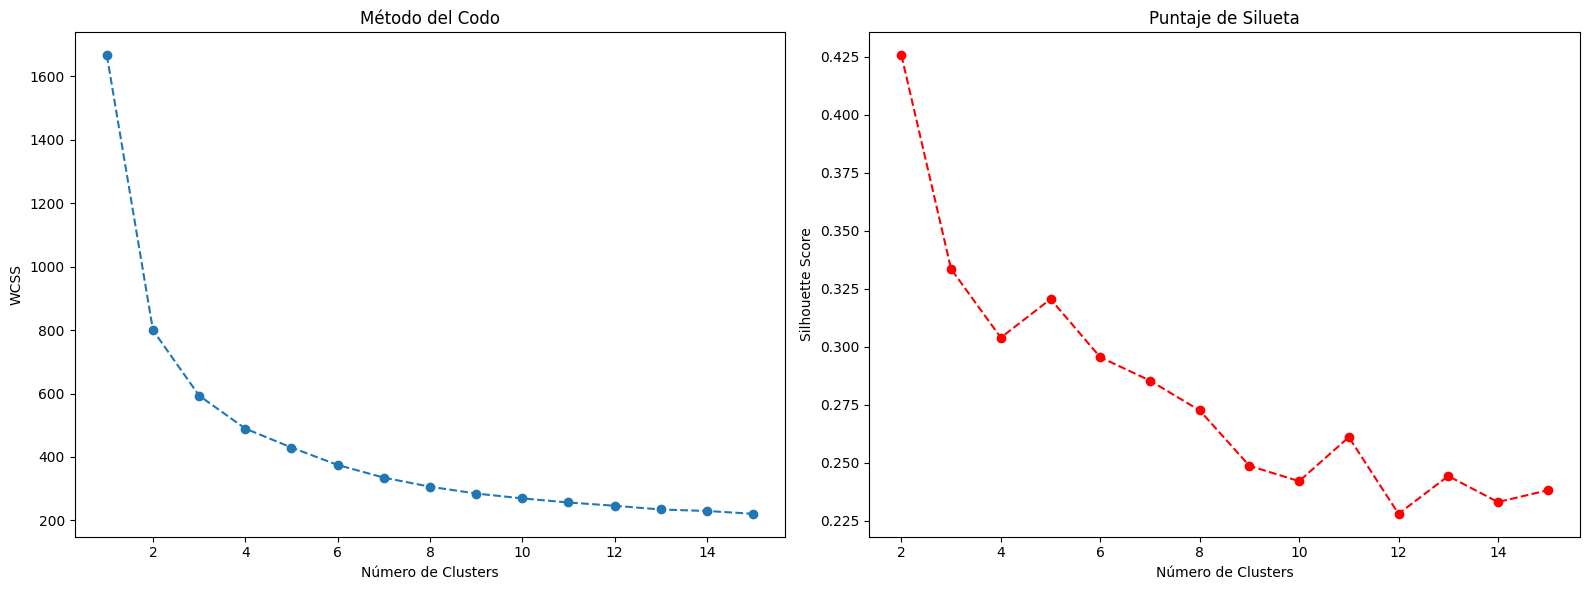

In [149]:
# 4. Método del codo para determinar el número óptimo de clusters
wcss = []  # List for the within-cluster sum of squares (WCSS)
silhouette_scores = []  # Para calcular el puntaje de silueta

for k in range(1, 16):  # Probar con diferentes valores de K (1 a 10)
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_)
    wcss.append(kmeans.inertia_)  # WCSS es la inercia
    if k > 1:  # Calcular silhouette score a partir de k=2
        silhouette_avg = silhouette_score(X_, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

# 5. Graficar el método del codo
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), wcss, marker='o', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

# 6. Graficar el puntaje de silueta (opcional, pero útil para evaluar la calidad del cluster)
plt.subplot(1, 2, 2)
plt.plot(range(2, 16), silhouette_scores, marker='o', color='r', linestyle='--')
plt.title('Puntaje de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

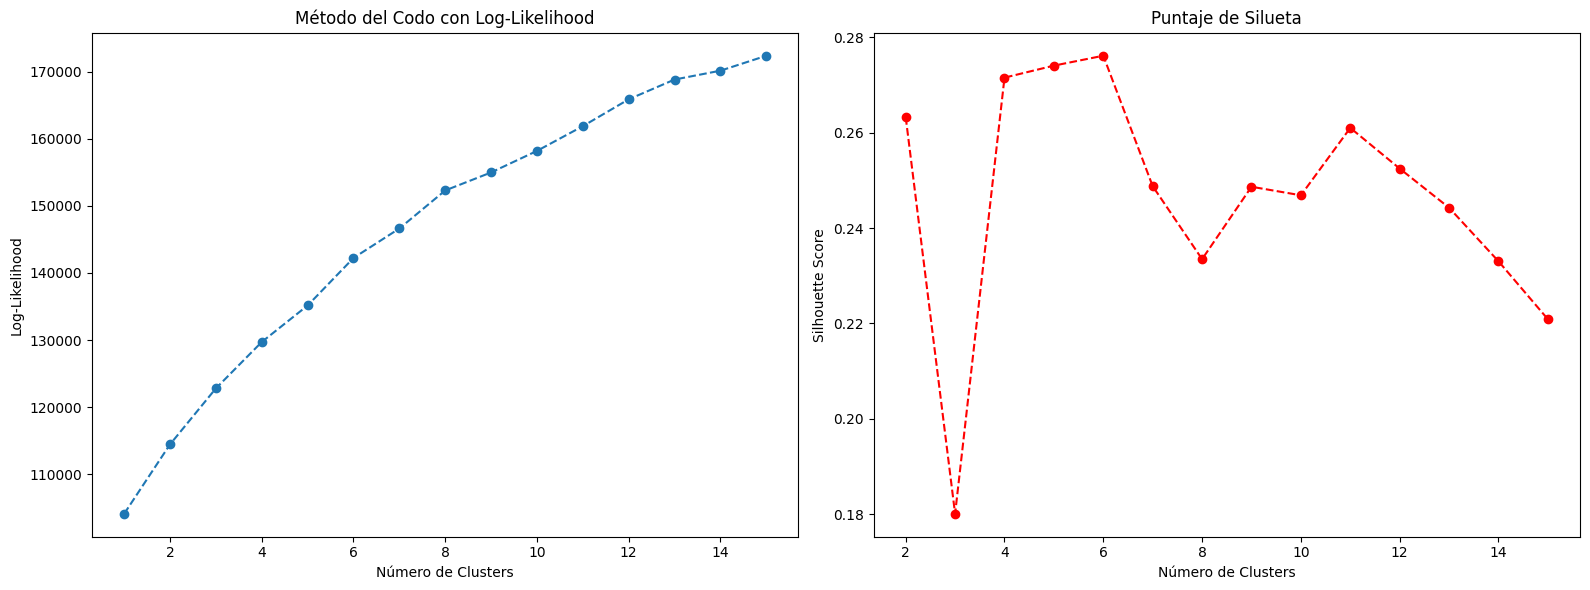

In [145]:
# Variables para almacenar resultados
log_likelihoods = []  # Log-likelihood para el método del codo
silhouette_scores = []  # Puntaje de silueta

# Probar con diferentes valores de K (número de clusters)
for k in range(1, 16):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_)
    log_likelihoods.append(gmm.score(X_) * len(X_))  # Log-likelihood total
    if k > 1:  # Calcular silhouette score a partir de k=2
        labels = gmm.predict(X_)
        silhouette_avg = silhouette_score(X_, labels)
        silhouette_scores.append(silhouette_avg)

# Graficar el método del codo con log-verosimilitud
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), log_likelihoods, marker='o', linestyle='--')
plt.title('Método del Codo con Log-Likelihood')
plt.xlabel('Número de Clusters')
plt.ylabel('Log-Likelihood')

# Graficar el puntaje de silueta
plt.subplot(1, 2, 2)
plt.plot(range(2, 16), silhouette_scores, marker='o', color='r', linestyle='--')
plt.title('Puntaje de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


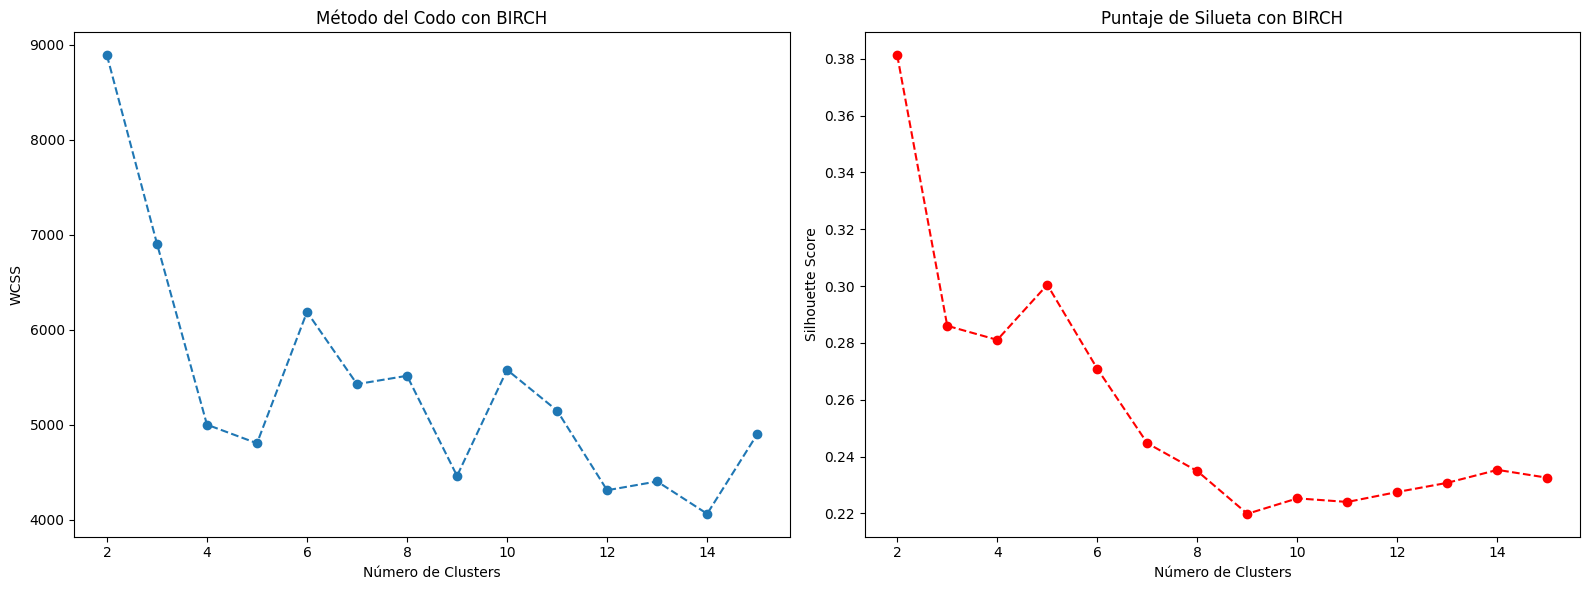

In [159]:
# Supongamos que 'X_' es el dataset preprocesado
wcss = []  # Lista para almacenar la suma de distancias dentro de los clusters
silhouette_scores = []  # Lista para los puntajes de silueta

# Probar con diferentes números de clusters
for k in range(2, 16):  # Birch necesita al menos 2 clusters para calcular scores
    birch = Birch(n_clusters=k, threshold=0.1)  # Ajusta el threshold si es necesario
    birch.fit(X_)
    labels = birch.labels_
    wcss.append(np.sum((X_ - birch.subcluster_centers_[labels])**2))  # Cálculo aproximado de WCSS
    silhouette_avg = silhouette_score(X_, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar los resultados
plt.figure(figsize=(16, 6))

# Método del Codo
plt.subplot(1, 2, 1)
plt.plot(range(2, 16), wcss, marker='o', linestyle='--')
plt.title('Método del Codo con BIRCH')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

# Puntaje de Silueta
plt.subplot(1, 2, 2)
plt.plot(range(2, 16), silhouette_scores, marker='o', color='r', linestyle='--')
plt.title('Puntaje de Silueta con BIRCH')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

### Selección de clústers
Utilizando el método del codo, aparentemente el número ideal de clústers a usar es 3, sin embargo, debido a que tenemos muchos clientes es muy poco realista pensar en realizar la clasificación con este número de agrupaciones, por lo que vamos a usar valores igual de buenos según la silueta, en este caso k=4 y k=8

In [160]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_)
df_clientes["kmeans_cluster"] = kmeans.labels_
df_clientes_m["kmeans_cluster"] = kmeans.labels_

gmm = GaussianMixture(n_components=6, covariance_type='full', random_state=42)
gmm.fit(X_)
gmm_labels = gmm.predict(X_)
df_clientes["gaussian_cluster"] = gmm_labels
df_clientes_m["gaussian_cluster"] = gmm_labels

birch = Birch(n_clusters=5, threshold=0.1)  # Ajusta el threshold si es necesario
birch.fit(X_)
df_clientes["birch_cluster"] = birch.labels_
df_clientes_m["birch_cluster"] = birch.labels_

df_clientes["Tipo"] = "Curva tipo"
df_clientes_m["Tipo"] = "Curva max"

In [161]:
df_clientes

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,22:30,22:45,23:00,23:15,23:30,23:45,kmeans_cluster,gaussian_cluster,birch_cluster,Tipo
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,0000-00-00,0.272003,0.000000,0.833077,0.834376,0.824798,0.822814,...,0.829261,0.825962,0.834900,0.826766,0.826964,0.837886,4,4,0,Curva tipo
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,0000-00-00,0.352398,0.001030,0.825360,0.828624,0.826263,0.827307,...,0.829951,0.830196,0.827308,0.828452,0.827328,0.827426,4,4,0,Curva tipo
2,RECIPLAST C.A.,E3811.00,10026628,0000-00-00,0.835514,0.004700,0.615247,0.605026,0.589301,0.589156,...,0.618228,0.600500,0.604258,0.625588,0.636706,0.638801,4,0,0,Curva tipo
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,0000-00-00,0.523054,0.000000,0.234176,0.231056,0.223868,0.225640,...,0.276202,0.276165,0.282748,0.284638,0.284025,0.282701,1,3,2,Curva tipo
4,Desconocido,Desconocido,10033889,0000-00-00,1.577123,0.006601,0.124828,0.133934,0.128756,0.126702,...,0.124206,0.137678,0.130348,0.138064,0.136666,0.130934,1,2,3,Curva tipo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,SIGMAPLAST,Desconocido,Desconocido,0000-00-00,7103.640000,0.000000,0.694344,0.696171,0.697165,0.698702,...,0.713191,0.712133,0.709766,0.711158,0.711458,0.714425,4,4,0,Curva tipo
374,SINTOFIL,Desconocido,Desconocido,0000-00-00,1479.480000,0.000000,0.514298,0.513626,0.512433,0.512842,...,0.571798,0.561596,0.559882,0.565276,0.566784,0.569124,4,0,0,Curva tipo
375,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,0000-00-00,407.452000,0.000000,0.509591,0.513217,0.543960,0.576485,...,0.435446,0.478534,0.503097,0.527862,0.525922,0.517069,0,5,0,Curva tipo
376,TEXTILES TEXSA,Desconocido,Desconocido,0000-00-00,774.860000,0.000000,0.566070,0.568113,0.566743,0.568308,...,0.586311,0.585818,0.592824,0.599960,0.601584,0.601834,4,0,0,Curva tipo


In [74]:
df_clientes_m

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,22:30,22:45,23:00,23:15,23:30,23:45,kmeans_cluster,gaussian_cluster,birch_cluster,Tipo
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,2023-12-26,0.272003,0.0,0.979859,0.94371,0.970032,0.958215,...,0.886498,0.928095,0.906847,0.899845,0.865084,0.935303,3,1,1,Curva max
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,2023-08-24,0.352398,0.00103,0.844897,0.838066,0.843189,0.842905,...,0.841197,0.858842,0.838066,0.834367,0.852866,0.833228,3,1,1,Curva max
2,RECIPLAST C.A.,E3811.00,10026628,2023-09-06,0.835514,0.0047,0.896742,0.910789,0.931013,0.888858,...,0.888131,0.928168,0.894945,0.887098,0.856103,0.941462,3,3,1,Curva max
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,2024-01-18,0.523054,0.0,0.6744,0.681722,0.689756,0.656754,...,0.007265,0.006883,0.007074,0.007456,0.007074,0.006883,1,2,0,Curva max
4,Desconocido,Desconocido,Desconocido,2023-06-16,1.577123,0.006601,0.390944,0.403446,0.372298,0.299738,...,0.100288,0.064165,0.06609,0.224087,0.549842,0.371203,1,2,0,Curva max
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,SIGMAPLAST,Desconocido,Desconocido,2023-12-15,7103.64,0.0,0.837834,0.83859,0.816793,0.847409,...,0.814304,0.788631,0.812722,0.827741,0.839684,0.890164,3,1,1,Curva max
588,SINTOFIL,Desconocido,Desconocido,2023-02-14,1479.48,0.0,0.897929,0.870149,0.886222,0.933214,...,0.909582,0.92267,0.913897,0.854695,0.900084,0.931208,3,3,2,Curva max
589,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,2023-04-28,407.452,0.0,0.4149,0.482894,0.601808,0.607964,...,0.585581,0.382043,0.610948,0.502813,0.560076,0.450556,2,0,2,Curva max
590,TEXTILES TEXSA,Desconocido,Desconocido,2023-05-10,774.86,0.0,0.736179,0.745167,0.742498,0.754046,...,0.79903,0.715995,0.849222,0.866753,0.802865,0.819957,3,3,2,Curva max


In [162]:
df_concat = pd.concat([df_clientes, df_clientes_m])

In [163]:
df_concat

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,22:30,22:45,23:00,23:15,23:30,23:45,kmeans_cluster,gaussian_cluster,birch_cluster,Tipo
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,0000-00-00,0.272003,0.0,0.833077,0.834376,0.824798,0.822814,...,0.829261,0.825962,0.8349,0.826766,0.826964,0.837886,4,4,0,Curva tipo
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,0000-00-00,0.352398,0.00103,0.82536,0.828624,0.826263,0.827307,...,0.829951,0.830196,0.827308,0.828452,0.827328,0.827426,4,4,0,Curva tipo
2,RECIPLAST C.A.,E3811.00,10026628,0000-00-00,0.835514,0.0047,0.615247,0.605026,0.589301,0.589156,...,0.618228,0.6005,0.604258,0.625588,0.636706,0.638801,4,0,0,Curva tipo
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,0000-00-00,0.523054,0.0,0.234176,0.231056,0.223868,0.22564,...,0.276202,0.276165,0.282748,0.284638,0.284025,0.282701,1,3,2,Curva tipo
4,Desconocido,Desconocido,10033889,0000-00-00,1.577123,0.006601,0.124828,0.133934,0.128756,0.126702,...,0.124206,0.137678,0.130348,0.138064,0.136666,0.130934,1,2,3,Curva tipo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,SIGMAPLAST,Desconocido,Desconocido,2023-12-15,7103.64,0.0,0.837834,0.83859,0.816793,0.847409,...,0.814304,0.788631,0.812722,0.827741,0.839684,0.890164,4,4,0,Curva max
374,SINTOFIL,Desconocido,Desconocido,2023-02-14,1479.48,0.0,0.897929,0.870149,0.886222,0.933214,...,0.909582,0.92267,0.913897,0.854695,0.900084,0.931208,4,0,0,Curva max
375,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,2023-04-28,407.452,0.0,0.4149,0.482894,0.601808,0.607964,...,0.585581,0.382043,0.610948,0.502813,0.560076,0.450556,0,5,0,Curva max
376,TEXTILES TEXSA,Desconocido,Desconocido,2023-05-10,774.86,0.0,0.736179,0.745167,0.742498,0.754046,...,0.79903,0.715995,0.849222,0.866753,0.802865,0.819957,4,0,0,Curva max


In [164]:
df_concat.to_csv("clientes_clasificados_por_curva_tipo.csv", index=False)

#### Obtención de los entregables

Una vez tenemos cada clientes clasificados, tanto para k=4 como para k=8, debemos obtener en una carpeta separada por cluster, y por cliente, los siguientes entregables:
- Curva tipo en formato .png
- Curva del día de demanda máxima en .png
- Datos de la curva tipo en un .csv
- Datos de la curva del día de demanda máxima en un .csv
- Potencia aparente máxima y mínima en un .txt

Nota: El último archivo es necesario debido a que los datos están normalizados con un escalador max-min, y con estos valores podemos obtener el valor original de potencia para ese cliente.

In [165]:
df_clientes_clasificados = pd.read_csv("clientes_clasificados_por_curva_tipo.csv")
df_clientes_clasificados["CODIGOCLIE"] = df_clientes_clasificados["CODIGOCLIE"].astype("string")
df_clientes_clasificados["Nombre"] = df_clientes_clasificados["Nombre"].astype("string")
df_clientes_clasificados

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,22:30,22:45,23:00,23:15,23:30,23:45,kmeans_cluster,gaussian_cluster,birch_cluster,Tipo
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,0000-00-00,0.272003,0.000000,0.833077,0.834376,0.824798,0.822814,...,0.829261,0.825962,0.834900,0.826766,0.826964,0.837886,4,4,0,Curva tipo
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,0000-00-00,0.352398,0.001030,0.825360,0.828624,0.826263,0.827307,...,0.829951,0.830196,0.827308,0.828452,0.827328,0.827426,4,4,0,Curva tipo
2,RECIPLAST C.A.,E3811.00,10026628,0000-00-00,0.835514,0.004700,0.615247,0.605026,0.589301,0.589156,...,0.618228,0.600500,0.604258,0.625588,0.636706,0.638801,4,0,0,Curva tipo
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,0000-00-00,0.523054,0.000000,0.234176,0.231056,0.223868,0.225640,...,0.276202,0.276165,0.282748,0.284638,0.284025,0.282701,1,3,2,Curva tipo
4,Desconocido,Desconocido,10033889,0000-00-00,1.577123,0.006601,0.124828,0.133934,0.128756,0.126702,...,0.124206,0.137678,0.130348,0.138064,0.136666,0.130934,1,2,3,Curva tipo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,SIGMAPLAST,Desconocido,Desconocido,2023-12-15,7103.640000,0.000000,0.837834,0.838590,0.816793,0.847409,...,0.814304,0.788631,0.812722,0.827741,0.839684,0.890164,4,4,0,Curva max
752,SINTOFIL,Desconocido,Desconocido,2023-02-14,1479.480000,0.000000,0.897929,0.870149,0.886222,0.933214,...,0.909582,0.922670,0.913897,0.854695,0.900084,0.931208,4,0,0,Curva max
753,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,2023-04-28,407.452000,0.000000,0.414900,0.482894,0.601808,0.607964,...,0.585581,0.382043,0.610948,0.502813,0.560076,0.450556,0,5,0,Curva max
754,TEXTILES TEXSA,Desconocido,Desconocido,2023-05-10,774.860000,0.000000,0.736179,0.745167,0.742498,0.754046,...,0.799030,0.715995,0.849222,0.866753,0.802865,0.819957,4,0,0,Curva max


In [166]:
def graficar_curva_tipo(columnas, valores, cod_cli, path):

    # Graficar
    plt.figure(figsize=(16, 6))
    plt.plot(columnas, valores, marker='o', color='b', linestyle='-', label='Potencia Aparente Escalada')
    plt.title(f'Curva tipo cliente {cod_cli.split(".")[0]}')
    plt.xlabel('Hora')
    plt.ylabel('Potencia Aparente Escalada')
    plt.grid(True)
    #plt.legend()
    plt.xticks(columnas[::2], rotation=45)  # Si las horas se ven muy amontonadas, rota las etiquetas del eje X
    plt.tight_layout()  # Ajusta para evitar recortes en las etiquetas
    
    #plt.show()

    # Guardar la gráfica en un archivo (por ejemplo, como archivo PNG)
    plt.savefig(f"{path}/curva_tipo_{cod_cli.split('.')[0]}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.
    
    # No se muestra la gráfica, solo se guarda
    plt.close()  # Esto cierra la figura después de guardarla para liberar recursos

def graficar_dia_max_demanda(columnas, valores, cod_cli, path, fecha):

    # Graficar la potencia aparente escalada a lo largo del día
    plt.figure(figsize=(16, 6))
    plt.plot(columnas, valores, marker='o', color='r', linestyle='-', label=f'Potencia Aparente Escalada')
    plt.title(f'Curva del día de demanda máxima {fecha} para cliente {cod_cli.split(".")[0]}')
    plt.xlabel('Hora')
    plt.ylabel('Potencia Aparente Escalada')
    plt.grid(True)
    plt.legend()
    plt.xticks(columnas[::2], rotation=45)
    plt.tight_layout()
    
    #plt.show()

    # Guardar la gráfica en un archivo (por ejemplo, como archivo PNG)
    plt.savefig(f"{path}/curva_dia_demanda_max_{cod_cli.split('.')[0]}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.
    
    # No se muestra la gráfica, solo se guarda
    plt.close()  # Esto cierra la figura después de guardarla para liberar recursos

In [173]:
# Primero hagamos con K3

clusters = df_clientes_clasificados["kmeans_cluster"].unique()
carpeta_guardar = r"kmeans_cluster"
cols = df_clientes_clasificados.columns[6:-4].values

print(cols)
print(clusters)

['00:00' '00:15' '00:30' '00:45' '01:00' '01:15' '01:30' '01:45' '02:00'
 '02:15' '02:30' '02:45' '03:00' '03:15' '03:30' '03:45' '04:00' '04:15'
 '04:30' '04:45' '05:00' '05:15' '05:30' '05:45' '06:00' '06:15' '06:30'
 '06:45' '07:00' '07:15' '07:30' '07:45' '08:00' '08:15' '08:30' '08:45'
 '09:00' '09:15' '09:30' '09:45' '10:00' '10:15' '10:30' '10:45' '11:00'
 '11:15' '11:30' '11:45' '12:00' '12:15' '12:30' '12:45' '13:00' '13:15'
 '13:30' '13:45' '14:00' '14:15' '14:30' '14:45' '15:00' '15:15' '15:30'
 '15:45' '16:00' '16:15' '16:30' '16:45' '17:00' '17:15' '17:30' '17:45'
 '18:00' '18:15' '18:30' '18:45' '19:00' '19:15' '19:30' '19:45' '20:00'
 '20:15' '20:30' '20:45' '21:00' '21:15' '21:30' '21:45' '22:00' '22:15'
 '22:30' '22:45' '23:00' '23:15' '23:30' '23:45']
[4 1 0 2 3]


In [168]:
for k in clusters:
    clientes_agrupados = df_clientes_clasificados[df_clientes_clasificados["kmeans_cluster"]==k].copy()

    for index, row in clientes_agrupados.iterrows():
        cod_cli = row["CODIGOCLIE"].strip()

        if cod_cli == "Desconocido":
            cod_cli = row["Nombre"].strip()
            
        print(f"Iterando sobre cliente {cod_cli}")
        
        path = rf"{carpeta_guardar}/{k}/{cod_cli}"
        os.makedirs(path, exist_ok=True)

        if row["Tipo"] == "Curva tipo":
            valores = row[6:-3].values
            
            #Guardar un .csv con los datos de la curva tipo
            #print(f"{len(valores)}     {len(cols)}")
            df_datos_ctipo = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_ctipo.to_csv(rf"{path}/datos_curva_tipo.csv", index=False)

            #Guardar la img de la curva tipo
            graficar_curva_tipo(cols, valores, cod_cli, path)

            #Guardar .txt con potencia aparente máxima y mínima
            open(rf'{path}\archivo.txt', 'w').write(f'Pot_aparente_max: {row["Max_potencia_ap"]}\nPot_aparente_min: {row["Min_potencia_ap"]}')

            #Liberar memoria
            del df_datos_ctipo
            gc.collect()
        elif row["Tipo"] == "Curva max":
            valores = row[6:-3].values

            #Guardar un .csv con los datos de la curva del dia de demanda max
            df_datos_cmax = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_cmax.to_csv(rf"{path}/datos_dia_demanda_max.csv", index=False)

            #Guardar la img de curva del dia de demanda max
            graficar_dia_max_demanda(cols, valores, cod_cli, path, row["Fecha"])

            #Liberar memoria
            del df_datos_cmax
            gc.collect()

    del clientes_agrupados
    gc.collect()

Iterando sobre cliente 10016608
Iterando sobre cliente 10020880
Iterando sobre cliente 10026628
Iterando sobre cliente 10055028
Iterando sobre cliente 10062892
Iterando sobre cliente 10069995
Iterando sobre cliente 10103654
Iterando sobre cliente 10188848
Iterando sobre cliente 1188682
Iterando sobre cliente 1211510
Iterando sobre cliente 1220802
Iterando sobre cliente 1240866
Iterando sobre cliente 1272327
Iterando sobre cliente 1297776
Iterando sobre cliente 1509608
Iterando sobre cliente 1514631
Iterando sobre cliente 1628519
Iterando sobre cliente 1665927
Iterando sobre cliente 1688599
Iterando sobre cliente 1812489
Iterando sobre cliente 1813455
Iterando sobre cliente 1940609
Iterando sobre cliente 1989800
Iterando sobre cliente 2007475
Iterando sobre cliente 90000309
Iterando sobre cliente 90000515
Iterando sobre cliente 90000537
Iterando sobre cliente 90000540
Iterando sobre cliente 90000657
Iterando sobre cliente 90000688
Iterando sobre cliente 90000762
Iterando sobre cliente 9

In [169]:
clusters = df_clientes_clasificados["gaussian_cluster"].unique()
carpeta_guardar = r"gaussian_cluster"

for k in clusters:
    clientes_agrupados = df_clientes_clasificados[df_clientes_clasificados["gaussian_cluster"]==k].copy()

    for index, row in clientes_agrupados.iterrows():
        cod_cli = row["CODIGOCLIE"].strip()

        if cod_cli == "Desconocido":
            cod_cli = row["Nombre"].strip()
            
        print(f"Iterando sobre cliente {cod_cli}")
        
        path = rf"{carpeta_guardar}/{k}/{cod_cli}"
        os.makedirs(path, exist_ok=True)

        if row["Tipo"] == "Curva tipo":
            valores = row[6:-3].values
            
            #Guardar un .csv con los datos de la curva tipo
            #print(f"{len(valores)}     {len(cols)}")
            df_datos_ctipo = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_ctipo.to_csv(rf"{path}/datos_curva_tipo.csv", index=False)

            #Guardar la img de la curva tipo
            graficar_curva_tipo(cols, valores, cod_cli, path)

            #Guardar .txt con potencia aparente máxima y mínima
            open(rf'{path}\archivo.txt', 'w').write(f'Pot_aparente_max: {row["Max_potencia_ap"]}\nPot_aparente_min: {row["Min_potencia_ap"]}')

            #Liberar memoria
            del df_datos_ctipo
            gc.collect()
        elif row["Tipo"] == "Curva max":
            valores = row[6:-3].values

            #Guardar un .csv con los datos de la curva del dia de demanda max
            df_datos_cmax = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_cmax.to_csv(rf"{path}/datos_dia_demanda_max.csv", index=False)

            #Guardar la img de curva del dia de demanda max
            graficar_dia_max_demanda(cols, valores, cod_cli, path, row["Fecha"])

            #Liberar memoria
            del df_datos_cmax
            gc.collect()

    del clientes_agrupados
    gc.collect()

Iterando sobre cliente 10016608
Iterando sobre cliente 10020880
Iterando sobre cliente 10188848
Iterando sobre cliente 1188682
Iterando sobre cliente 1514631
Iterando sobre cliente 1628519
Iterando sobre cliente 2007475
Iterando sobre cliente 90000688
Iterando sobre cliente 90000762
Iterando sobre cliente 90002093
Iterando sobre cliente 90002102
Iterando sobre cliente 90002274
Iterando sobre cliente ALIMENTOS SUPERIOR
Iterando sobre cliente EDESA MORAN VALVERDE
Iterando sobre cliente EDESA PARQUE INDUSTRIAL
Iterando sobre cliente ESTACIÓN DE BOMBEO CHIRIYACU ALTO
Iterando sobre cliente ESTACIÓN DE BOMBEO CHIRIYACU MEDIO
Iterando sobre cliente ESTACIÓN DE BOMBEO COLINAS ALTO
Iterando sobre cliente ESTACIÓN DE BOMBEO LIBERTAD MEDIO
Iterando sobre cliente ESTACIÓN DE BOMBEO ROLDOS MEDIO
Iterando sobre cliente FLEXIPLAST
Iterando sobre cliente GC EMPAQPLAST
Iterando sobre cliente HILTEXPOY 1
Iterando sobre cliente INGESA 2 MARISCAL SUCRE
Iterando sobre cliente INT FOOD SERVICES CORP
Iteran

In [170]:
clusters = df_clientes_clasificados["birch_cluster"].unique()
carpeta_guardar = r"birch_cluster"

for k in clusters:
    clientes_agrupados = df_clientes_clasificados[df_clientes_clasificados["birch_cluster"]==k].copy()

    for index, row in clientes_agrupados.iterrows():
        cod_cli = row["CODIGOCLIE"].strip()

        if cod_cli == "Desconocido":
            cod_cli = row["Nombre"].strip()
            
        print(f"Iterando sobre cliente {cod_cli}")
        
        path = rf"{carpeta_guardar}/{k}/{cod_cli}"
        os.makedirs(path, exist_ok=True)

        if row["Tipo"] == "Curva tipo":
            valores = row[6:-3].values
            
            #Guardar un .csv con los datos de la curva tipo
            #print(f"{len(valores)}     {len(cols)}")
            df_datos_ctipo = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_ctipo.to_csv(rf"{path}/datos_curva_tipo.csv", index=False)

            #Guardar la img de la curva tipo
            graficar_curva_tipo(cols, valores, cod_cli, path)

            #Guardar .txt con potencia aparente máxima y mínima
            open(rf'{path}\archivo.txt', 'w').write(f'Pot_aparente_max: {row["Max_potencia_ap"]}\nPot_aparente_min: {row["Min_potencia_ap"]}')

            #Liberar memoria
            del df_datos_ctipo
            gc.collect()
        elif row["Tipo"] == "Curva max":
            valores = row[6:-3].values

            #Guardar un .csv con los datos de la curva del dia de demanda max
            df_datos_cmax = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_cmax.to_csv(rf"{path}/datos_dia_demanda_max.csv", index=False)

            #Guardar la img de curva del dia de demanda max
            graficar_dia_max_demanda(cols, valores, cod_cli, path, row["Fecha"])

            #Liberar memoria
            del df_datos_cmax
            gc.collect()

    del clientes_agrupados
    gc.collect()

Iterando sobre cliente 10016608
Iterando sobre cliente 10020880
Iterando sobre cliente 10026628
Iterando sobre cliente 10055028
Iterando sobre cliente 10062892
Iterando sobre cliente 10069995
Iterando sobre cliente 10103654
Iterando sobre cliente 10188848
Iterando sobre cliente 1093087
Iterando sobre cliente 1134959
Iterando sobre cliente 1188682
Iterando sobre cliente 1211510
Iterando sobre cliente 1220802
Iterando sobre cliente 1240866
Iterando sobre cliente 1272327
Iterando sobre cliente 1297776
Iterando sobre cliente 1376595
Iterando sobre cliente 1497952
Iterando sobre cliente 1509608
Iterando sobre cliente 1514631
Iterando sobre cliente 1528782
Iterando sobre cliente 1565547
Iterando sobre cliente 1581796
Iterando sobre cliente 1582042
Iterando sobre cliente 1582648
Iterando sobre cliente 1628519
Iterando sobre cliente 1665927
Iterando sobre cliente 1688599
Iterando sobre cliente 1812489
Iterando sobre cliente 1813455
Iterando sobre cliente 1940609
Iterando sobre cliente 1989800


#### Finalmente, obtener curva tipo para cada clúster obtenido

In [8]:
clustersK6 = os.scandir("clustersK6")

for cluster in clustersK6:
    clientes = os.scandir(rf"clustersK6/{cluster.name}")
    df_datos_por_cluster = pd.DataFrame()
    for cliente in clientes:
        df_curva_tipo = pd.read_csv(rf"clustersK6/{cluster.name}/{cliente.name}/datos_curva_tipo.csv")
        df_datos_por_cluster = pd.concat([df_datos_por_cluster, df_curva_tipo])

    grouped_df = df_datos_por_cluster.groupby("Hora")["Potencia aparente escalada"].apply(func="mean").sort_index(ascending=True).reset_index()
    grouped_df.to_csv(rf"clustersK6/{cluster.name}/curva_tipo_cluster.csv", index=False)


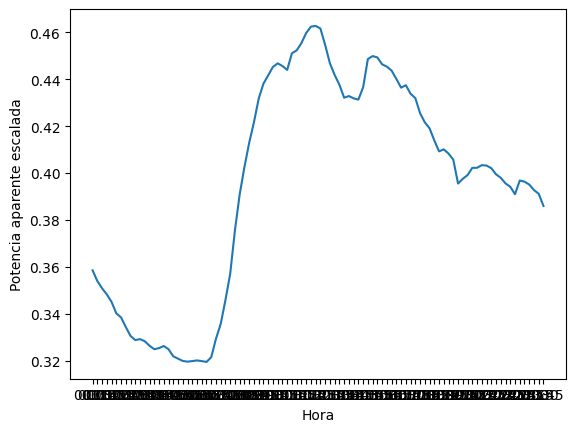

In [20]:
df_cluster_4 = pd.read_csv(rf"clustersK6\5\curva_tipo_cluster.csv")

sns.lineplot(data= df_cluster_4, x="Hora", y="Potencia aparente escalada")
plt.show()

In [27]:
df_p = pd.read_csv("mediciones_anio_limpias_norm\perfil_carga_anual_limpio-1400880901.0-2023.csv")
min_v = df_p["Potencia_aparente"].min()
max_v = df_p["Potencia_aparente"].max()
print(min_v)
print(max_v)
print(0.099980*(max_v-min_v)+min_v)
print(df_p)

0.0032310988842807
0.3578385110633008
0.03868474795393913
            Fecha          Origen  Demanda activa DEL  Demanda reactiva DEL  \
0      2023-02-01  Lectura manual              0.0354                0.0156   
1      2023-02-01  Lectura manual              0.0372                0.0132   
2      2023-02-01  Lectura manual              0.0366                0.0126   
3      2023-02-01  Lectura manual              0.0348                0.0120   
4      2023-02-01  Lectura manual              0.0378                0.0138   
...           ...             ...                 ...                   ...   
18907  2023-12-29     Lectura AMR              0.1590                0.0558   
18908  2023-12-29     Lectura AMR              0.1662                0.0564   
18909  2023-12-29     Lectura AMR              0.1362                0.0384   
18910  2023-12-29     Lectura AMR              0.1566                0.0516   
18911  2023-12-29     Lectura AMR              0.1632                0.05

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\S0771\AppData\Local\Temp\ipykernel_13308\2847002045.py:1: SyntaxWarning: invalid escape sequence '\p'
  df_p = pd.read_csv("mediciones_anio_limpias_norm\perfil_carga_anual_limpio-1400880901.0-2023.csv")
